In [1]:
import sys,os,os.path
sys.path.append("../../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



In [2]:
print(np.__version__)

1.20.3


In [3]:


def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df



### lets try and load the sophronia stuff here

In [4]:
# loading sophronia file
#soph_file = f'../../../next_misc/Tl_studies/sophronia/sophronia_qthr2.h5'
soph_file = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/sophronia_27_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh

# Name of directory the plots are going into
#pre_dir_name = 'qthr2_plot/'

# set q_thr value here
thresh = 4


display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-225.475,0.0,0.0,369.512128,5.101449,236.734026,-1.0,0.000766,-1,-1.0
1,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-209.925,0.0,0.0,369.512128,10.144928,470.777938,-1.0,0.001512,-1,-1.0
2,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-241.025,0.0,0.0,369.512128,4.811594,223.283232,-1.0,0.000741,-1,-1.0
3,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-225.475,0.0,0.0,369.512128,13.913044,645.638310,-1.0,0.002115,-1,-1.0
4,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-209.925,0.0,0.0,369.512128,18.144928,842.019953,-1.0,0.002748,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147151,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,318.775,0.0,0.0,670.050544,5.913043,188.888896,-1.0,0.000849,-1,-1.0
147152,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,334.325,0.0,0.0,670.050544,5.275362,168.518515,-1.0,0.000608,-1,-1.0
147153,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,318.775,0.0,0.0,670.050544,6.492754,207.407411,-1.0,0.001296,-1,-1.0
147154,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,334.325,0.0,0.0,670.050544,4.521739,144.444446,-1.0,0.000521,-1,-1.0


### create lowTh

In [5]:
soph_lowTh = soph_to_lowTh(soph_hdst, threshold = thresh)
#display(soph_lowTh)

Processing data...
133/316
266/316


## SELECT BEERSHEBA PARAMETERS OF INTEREST HERE

In [6]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'../../../Tl_studies/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 9e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 75,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [7]:
deconv_params


{'drop_dist': [16.0, 16.0],
 'psf_fname': '../../../Tl_studies/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
 'q_cut': 4,
 'e_cut': 0.009,
 'n_iterations': 75,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1.0, 1.0],
 'energy_type': <HitEnergy.Ec: 'Ec'>,
 'diffusion': (1.44, 1.44),
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>,
 'n_dim': 2,
 'cut_type': <CutType.abs: 'abs'>,
 'inter_method': <InterpolationMethod.cubic: 'cubic'>}

### collect all the plots!

In [8]:
hdst = soph_lowTh

# print only event ids that exist within positron list
event_ids = np.load(f'../quick_notebooks/z_slice/positron_event_ids.npy')

for i in range(len(hdst.event.unique())):
	
	evt = hdst.event.unique()[i]

	# ONLY DO THE REST IF THIS EVENT IS IN THE LIST OF EVENT_IDS
	if (evt in event_ids):
		hits = hdst[hdst.event == evt]
		
		x_range = (hits.X.max()-hits.X.min())/2.
		y_range = (hits.Y.max()-hits.Y.min())/2.
		z_range = (hits.Z.max()-hits.Z.min())/2.
		mid_x   = (hits.X.max()+hits.X.min())/2.
		mid_y   = (hits.Y.max()+hits.Y.min())/2.
		mid_z   = (hits.Z.max()+hits.Z.min())/2.

		print("X maximum and minimum")
		print(hits.X.max(), hits.X.min())
		print("")

		print("Y maximum and minimum")
		print(hits.Y.max(), hits.Y.min())
		print("")

		print("Z maximum and minimum")
		print(hits.Z.max(), hits.Z.min())

		xbins = int(hits.X.max()-hits.X.min())
		ybins = int(hits.Y.max()-hits.Y.min())
		zbins = int((hits.Z.max()-hits.Z.min())/2.)
		
		
		if (datatype == 'MC'):
			evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
			true_info = mcio.load_mchits_df(soph_file).reset_index()
			true_info.event_id = true_info.event_id.map(evtmap.evt_number)
			
			
			this_evt_true_info = true_info[true_info.event_id == evt]

			xt = this_evt_true_info.x
			yt = this_evt_true_info.y
			zt = this_evt_true_info.z
			et = this_evt_true_info.energy*1000
		
		no = this_evt_true_info['event_id'].to_numpy()[0]
		file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
		dir_name = "Tl208_" + file_number + "_event_" + str(no)

		if not os.path.isdir(pre_dir_name + dir_name):
			os.mkdir(pre_dir_name +dir_name)
		
		
		# true data type plots
		if (datatype == 'MC'):
			fig, axes = plt.subplots(1, 3, figsize=(18, 4))
			axes[0].scatter(xt, yt,  alpha=0.1, color='red')
			axes[0].set_xlabel('X (mm)');
			axes[0].set_ylabel('Y (mm)');

			axes[1].scatter(xt, zt,  alpha=0.1, color='red')
			axes[1].set_xlabel('X (mm)');
			axes[1].set_ylabel('Z (mm)');

			axes[2].scatter(yt, zt,  alpha=0.1, color='red')
			axes[2].set_xlabel('Y (mm)');
			axes[2].set_ylabel('Z (mm)');
			
			fig.suptitle('True Hits_' + dir_name, fontsize=30)
			fig.savefig(pre_dir_name + dir_name + "/MC_hits")
			plt.close()
		
		# plotting sipm data normally
		# true data type plots

		fig, axes = plt.subplots(1, 3, figsize=(18, 4))
		axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
		axes[0].set_xlabel('X (mm)');
		axes[0].set_ylabel('Y (mm)');

		axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
		axes[1].set_xlabel('X (mm)');
		axes[1].set_ylabel('Z (mm)');

		axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
		axes[2].set_xlabel('Y (mm)');
		axes[2].set_ylabel('Z (mm)');


		fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
		fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")
		plt.close()
		
		
		
		# then applying transformations to convert to 'SiPM outputs'
		fig, axes = plt.subplots(1, 3, figsize=(18, 4))


		xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
		yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
		zz = hits.Z.unique()

		axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
		axes[0].set_xlabel('X (mm)');
		axes[0].set_ylabel('Y (mm)');

		axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
		axes[1].set_xlabel('X (mm)');
		axes[1].set_ylabel('Z (mm)');


		axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
		axes[2].set_xlabel('Y (mm)');
		axes[2].set_ylabel('Z (mm)');

		fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
		fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")
		plt.close()
		
		

		# q_cut
		qmin = deconv_params['q_cut']
		print(f'Cutting sensors below {qmin}')
		
		hits_cut = coref.timefunc(cut_sensors)(hits.copy())
		
		
		fig, axes = plt.subplots(1, 3, figsize=(18, 4))

		xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
		yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
		zz = hits.Z.unique()

		axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
		axes[0].set_xlabel('X (mm)');
		axes[0].set_ylabel('Y (mm)');

		axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
		axes[1].set_xlabel('X (mm)');
		axes[1].set_ylabel('Z (mm)');


		axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
		axes[2].set_xlabel('Y (mm)');
		axes[2].set_ylabel('Z (mm)');


		fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
		fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")
		plt.close()
		
		
		cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
		hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())
		
		
		fig, axes = plt.subplots(1, 3, figsize=(18, 4))

		xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
		yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
		zz = hits.Z.unique()

		axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
		axes[0].set_xlabel('X (mm)');
		axes[0].set_ylabel('Y (mm)');

		axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
		axes[1].set_xlabel('X (mm)');
		axes[1].set_ylabel('Z (mm)');

		axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
		axes[2].set_xlabel('Y (mm)');
		axes[2].set_ylabel('Z (mm)');
		plt.close()
		
		
		print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
		print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
		print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')
		
		
		hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
		
		
		fig, axes = plt.subplots(1, 3, figsize=(18, 4))

		xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
		yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
		zz = hits.Z.unique()

		axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
		axes[0].set_xlabel('X (mm)');
		axes[0].set_ylabel('Y (mm)');

		axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
		axes[1].set_xlabel('X (mm)');
		axes[1].set_ylabel('Z (mm)');


		axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
		axes[2].set_xlabel('Y (mm)');
		axes[2].set_ylabel('Z (mm)');

		fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
		fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")
		plt.close()
		
		print(f'Energy (corrected) before drop: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
		print(f'Energy (corrected) after  drop: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')
		
		hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
		hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
		
		
		deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
		hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
		
		
		# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
		if 'save_state' in locals():
			deconv_params_['n_iterations'] = save_state
		else:
			# first time round, so set it
			save_state = deconv_params_['n_iterations']
		print(save_state)
		
		
		
			
		for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
			deconv_params_['n_iterations'] = iterN
			deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
			print(f'{iterN} iterations')
			hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
			
			
		fig, axes = plt.subplots(1, 3, figsize=(18, 4))

		xx = np.arange(hits.X.min(), hits.X.max())
		yy = np.arange(hits.Y.min(), hits.Y.max())
		zz = hits.Z.unique()

		axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
		if (datatype == 'MC'):
			axes[0].scatter(xt, yt,  alpha=0.1, color='red')
		axes[0].set_xlabel('X (mm)');
		axes[0].set_ylabel('Y (mm)');

		axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
		if (datatype == 'MC'):
			axes[1].scatter(xt, zt,  alpha=0.1, color='red')
		axes[1].set_xlabel('X (mm)');
		axes[1].set_ylabel('Z (mm)');

		axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
		if (datatype == 'MC'):
			axes[2].scatter(yt, zt,  alpha=0.1, color='red')
		axes[2].set_xlabel('Y (mm)');
		axes[2].set_ylabel('Z (mm)');
		plt.close()


		fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
		fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")
		
		x = hits_deco.X
		y = hits_deco.Y
		z = hits_deco.Z
		e = hits_deco.E*1000
		
		
		fig = plt.figure()
		ax = fig.add_subplot(111, projection='3d')

		p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
		cb = fig.colorbar(p, ax=ax)
		cb.set_label('Energy (keV)')

		ax.set_xlabel('x (mm)')
		ax.set_ylabel('y (mm)')
		ax.set_zlabel('z (mm)')

		fig.suptitle('3D_deconvolved_plot_' + dir_name)
		fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

		plt.close()
		
		# voxel size here
		base_vsize = 15 #mm
		the_hits = []

		xs = hits_deco.X
		ys = hits_deco.Y
		zs = hits_deco.Z
		es = hits_deco.E

		for x, y, z, e in zip(xs, ys, zs, es):
			if np.isnan(e): continue
			h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
			the_hits.append(h)

		voxels = voxelize_hits(the_hits,
						np.array([base_vsize, base_vsize, base_vsize]), False)

		vsizex = voxels[0].size[0]
		vsizey = voxels[0].size[1]
		vsizez = voxels[0].size[2]

		min_corner_x = min(v.X for v in voxels) - vsizex/2.
		min_corner_y = min(v.Y for v in voxels) - vsizey/2.
		min_corner_z = min(v.Z for v in voxels) - vsizez/2.

		x = [np.round(v.X/vsizex) for v in voxels]
		y = [np.round(v.Y/vsizey) for v in voxels]
		z = [np.round(v.Z/vsizez) for v in voxels]
		e = [v.E for v in voxels]

		x_min = int(min(x))
		y_min = int(min(y))
		z_min = int(min(z))

		x_max = int(max(x))
		y_max = int(max(y))
		z_max = int(max(z))

		#print(f'X min = {x_min}, X max = {x_max}')
		#print(f'Y min = {y_min}, Y max = {y_max}')
		#print(f'Z min = {z_min}, Z max = {z_max}')

		VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
		#print(VOXELS.shape)

		# sort through the event set the "turn on" the hit voxels
		cmap = cm.viridis
		norm = Normalize(vmin=0, vmax=max(e))

		colors = np.empty(VOXELS.shape, dtype=object)
		for q in range(0,len(z)):
			VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
			colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

		# and plot everything
		fig = plt.figure(figsize=(8,8))
		ax = fig.gca(projection='3d')
		#a,b,c is spacing in mm needs an extra dim
		a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
		a = a*vsizex + min_corner_x
		b = b*vsizey + min_corner_y
		c = c*vsizez + min_corner_z

		# a, b, c are the corners of the voxels
		ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

		ax.set_xlabel('x (mm)')#,fontsize=16)
		ax.set_ylabel('y (mm)')#,fontsize=16)
		ax.set_zlabel('z (mm)')#,fontsize=16)

		sm = cm.ScalarMappable(cmap=cmap, norm=norm)
		sm.set_array([])
		cb = fig.colorbar(sm)
		cb.set_label('Energy (keV)')

		fig.suptitle('voxelised_plot_' + dir_name)
		fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

		plt.close()

X maximum and minimum
489.825 -474.275

Y maximum and minimum
412.075 -474.275

Z maximum and minimum
1203.8310546875 634.6331176757812
Cutting sensors below 2
Time spent in cut_over_Q: 0.034273386001586914 s
Time spent in cut_over_Q: 0.034905433654785156 s
Energy (corrected) before cuts:    292667.9986818864 (1.0434242263074283)
Energy (corrected) after low cut:  292667.9986818864 (1.0434242263074283)
Energy (corrected) after high cut: 292667.99868188647 (1.0434242263074283)
Time spent in drop_isolated: 0.045152902603149414 s
Energy (corrected) before cut: 292667.9986818864 (1.0434242263074283)
Energy (corrected) after  cut: 292667.9986818865 (1.0434242263074283)
Time spent in cut_over_Q: 0.03763079643249512 s
Time spent in drop_isolated: 0.05019712448120117 s
Time spent in apply_deconvolution: 26.37613558769226 s
100
15 iterations
Time spent in apply_deconvolution: 4.41415548324585 s
30 iterations
Time spent in apply_deconvolution: 7.959140300750732 s
45 iterations
Time spent in appl

/tmp/ipykernel_38516/712064586.py:348: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


X maximum and minimum
489.825 -474.275

Y maximum and minimum
427.625 -474.275

Z maximum and minimum
510.7308349609375 316.6677551269531
Cutting sensors below 2
Time spent in cut_over_Q: 0.016442537307739258 s
Time spent in cut_over_Q: 0.019789695739746094 s
Energy (corrected) before cuts:    490523.0000858994 (1.7598838999147755)
Energy (corrected) after low cut:  490523.0000858994 (1.7598838999147755)
Energy (corrected) after high cut: 490523.0000858994 (1.7598838999147755)
Time spent in drop_isolated: 0.05875515937805176 s
Energy (corrected) before cut: 490523.0000858994 (1.7598838999147755)
Energy (corrected) after  cut: 490523.0000858995 (1.7598838999147755)
Time spent in cut_over_Q: 0.02008366584777832 s
Time spent in drop_isolated: 0.057350873947143555 s
Time spent in apply_deconvolution: 28.676482439041138 s
100
15 iterations
Time spent in apply_deconvolution: 5.997661352157593 s
30 iterations
Time spent in apply_deconvolution: 10.185012578964233 s
45 iterations
Time spent in 

KeyboardInterrupt: 

In [ ]:
### NORMAL FUNCTION ON ITS OWN

for i in range(len(hdst.event.unique())):
	evt = hdst.event.unique()[i]
	hits = hdst[hdst.event == evt]
	
	x_range = (hits.X.max()-hits.X.min())/2.
	y_range = (hits.Y.max()-hits.Y.min())/2.
	z_range = (hits.Z.max()-hits.Z.min())/2.
	mid_x   = (hits.X.max()+hits.X.min())/2.
	mid_y   = (hits.Y.max()+hits.Y.min())/2.
	mid_z   = (hits.Z.max()+hits.Z.min())/2.

	print("X maximum and minimum")
	print(hits.X.max(), hits.X.min())
	print("")

	print("Y maximum and minimum")
	print(hits.Y.max(), hits.Y.min())
	print("")

	print("Z maximum and minimum")
	print(hits.Z.max(), hits.Z.min())

	xbins = int(hits.X.max()-hits.X.min())
	ybins = int(hits.Y.max()-hits.Y.min())
	zbins = int((hits.Z.max()-hits.Z.min())/2.)
	
	
	if (datatype == 'MC'):
	    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
	    true_info = mcio.load_mchits_df(soph_file).reset_index()
	    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
	    
	    
	    this_evt_true_info = true_info[true_info.event_id == evt]

	    xt = this_evt_true_info.x
	    yt = this_evt_true_info.y
	    zt = this_evt_true_info.z
	    et = this_evt_true_info.energy*1000
	
	no = this_evt_true_info['event_id'].to_numpy()[0]
	file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
	dir_name = "Tl208_" + file_number + "_event_" + str(no)

	if not os.path.isdir(pre_dir_name + dir_name):
	    os.mkdir(pre_dir_name +dir_name)
	
	
	# true data type plots
	if (datatype == 'MC'):
	    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	    axes[0].set_xlabel('X (mm)');
	    axes[0].set_ylabel('Y (mm)');

	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	    axes[1].set_xlabel('X (mm)');
	    axes[1].set_ylabel('Z (mm)');

	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	    axes[2].set_xlabel('Y (mm)');
	    axes[2].set_ylabel('Z (mm)');
	    
	    fig.suptitle('True Hits_' + dir_name, fontsize=30)
	    fig.savefig(pre_dir_name + dir_name + "/MC_hits")
	    plt.close()
	   
	# plotting sipm data normally
	# true data type plots

	fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")
	plt.close()
	
	
	
	# then applying transformations to convert to 'SiPM outputs'
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))


	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")
	plt.close()
	
	
	qmin = deconv_params['q_cut']
	print(f'Cutting sensors below {qmin}')
	
	hits_cut = coref.timefunc(cut_sensors)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")
	plt.close()
	
	
	cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
	hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()
	
	
	print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
	print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')
	
	
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")
	plt.close()
	
	print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')
	
	hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	
	
	# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
	if 'save_state' in locals():
	    deconv_params_['n_iterations'] = save_state
	else:
	    # first time round, so set it
	    save_state = deconv_params_['n_iterations']
	print(save_state)
	
	
	
		
	for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
	    deconv_params_['n_iterations'] = iterN
	    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	    print(f'{iterN} iterations')
	    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	    
	    
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max())
	yy = np.arange(hits.Y.min(), hits.Y.max())
	zz = hits.Z.unique()

	axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()


	fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")
	
	x = hits_deco.X
	y = hits_deco.Y
	z = hits_deco.Z
	e = hits_deco.E*1000
	
	
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')

	p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
	cb = fig.colorbar(p, ax=ax)
	cb.set_label('Energy (keV)')

	ax.set_xlabel('x (mm)')
	ax.set_ylabel('y (mm)')
	ax.set_zlabel('z (mm)')

	fig.suptitle('3D_deconvolved_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

	plt.close()
	
	# voxel size here
	base_vsize = 15 #mm
	the_hits = []

	xs = hits_deco.X
	ys = hits_deco.Y
	zs = hits_deco.Z
	es = hits_deco.E

	for x, y, z, e in zip(xs, ys, zs, es):
	    if np.isnan(e): continue
	    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
	    the_hits.append(h)

	voxels = voxelize_hits(the_hits,
		               np.array([base_vsize, base_vsize, base_vsize]), False)

	vsizex = voxels[0].size[0]
	vsizey = voxels[0].size[1]
	vsizez = voxels[0].size[2]

	min_corner_x = min(v.X for v in voxels) - vsizex/2.
	min_corner_y = min(v.Y for v in voxels) - vsizey/2.
	min_corner_z = min(v.Z for v in voxels) - vsizez/2.

	x = [np.round(v.X/vsizex) for v in voxels]
	y = [np.round(v.Y/vsizey) for v in voxels]
	z = [np.round(v.Z/vsizez) for v in voxels]
	e = [v.E for v in voxels]

	x_min = int(min(x))
	y_min = int(min(y))
	z_min = int(min(z))

	x_max = int(max(x))
	y_max = int(max(y))
	z_max = int(max(z))

	#print(f'X min = {x_min}, X max = {x_max}')
	#print(f'Y min = {y_min}, Y max = {y_max}')
	#print(f'Z min = {z_min}, Z max = {z_max}')

	VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
	#print(VOXELS.shape)

	# sort through the event set the "turn on" the hit voxels
	cmap = cm.viridis
	norm = Normalize(vmin=0, vmax=max(e))

	colors = np.empty(VOXELS.shape, dtype=object)
	for q in range(0,len(z)):
	    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
	    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

	# and plot everything
	fig = plt.figure(figsize=(8,8))
	ax = fig.gca(projection='3d')
	#a,b,c is spacing in mm needs an extra dim
	a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
	a = a*vsizex + min_corner_x
	b = b*vsizey + min_corner_y
	c = c*vsizez + min_corner_z

	# a, b, c are the corners of the voxels
	ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

	ax.set_xlabel('x (mm)')#,fontsize=16)
	ax.set_ylabel('y (mm)')#,fontsize=16)
	ax.set_zlabel('z (mm)')#,fontsize=16)

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cb = fig.colorbar(sm)
	cb.set_label('Energy (keV)')

	fig.suptitle('voxelised_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

	plt.close()

## City Flow

#### Input SiPM Signal

SiPM signal which the city takes (esmeralda hits). 

#### this doesnt work as the esmeralda files dont have lowTh, but you've replaced them with your new soph_lowTh files!

In [7]:
#if(typefile == 'esmeralda'): hdst = dstio.load_dst(file, 'CHITS', 'lowTh')#CHITS/lowTh
#elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file, 'RECO', 'Events')#CHITS/lowTh

hdst = soph_lowTh

In [8]:
print(hdst['event'].unique())

[520000 520002 520004 520006 520008 520010 520012 520014 520016 520018
 520020 520022 520024 520026 520028 520030 520032 520034 520036 520040
 520042 520044 520046 520048 520050 520052 520054 520056 520058 520060
 520062 520064 520066 520068 520070 520072 520074 520076 520078 520080
 520082 520084 520086 520088 520090 520092 520094 520096 520098 520100
 520102 520104 520106 520108 520110 520112 520114 520116 520120 520122
 520124 520126 520128 520130 520132 520134 520136 520138 520140 520142
 520144 520146 520150 520152 520154 520156 520158 520160 520162 520164
 520166 520168 520170 520172 520174 520176 520178 520180 520182 520184
 520186 520188 520190 520192 520194 520196 520198 520200 520202 520204
 520206 520208 520210 520212 520214 520218 520220 520222 520224 520226
 520228 520230 520232 520234 520236 520238 520240 520242 520244 520246
 520248 520250 520252 520254 520256 520258 520260 520262 520264 520266
 520268 520270 520274 520276 520278 520280 520282 520284 520286 520288
 52029

Select event that is going to be visualized:

In [117]:
evt  = hdst.event.unique()[230]
print(evt)
print(evt/2)
hits = hdst[hdst.event == evt]

520470
260235.0


In [118]:
hits.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520470,5.204706e+11,0.0,-15.628242,3.905621,1.0,-7.775,69.975,0.0,0.0,877.749994,4.173913,339.000000,-1,0.001091,-1,-1
1,520470,5.204706e+11,0.0,-15.628242,3.905621,1.0,7.775,69.975,0.0,0.0,877.749994,4.173913,339.000000,-1,0.001091,-1,-1
2,520470,5.204706e+11,0.0,-15.628242,3.905621,1.0,-7.775,69.975,0.0,0.0,880.797553,5.507246,444.063383,-1,0.001430,-1,-1
3,520470,5.204706e+11,0.0,-15.628242,3.905621,1.0,7.775,54.425,0.0,0.0,880.797553,9.797101,789.965403,-1,0.002544,-1,-1
4,520470,5.204706e+11,0.0,-15.628242,3.905621,1.0,7.775,69.975,0.0,0.0,880.797553,4.753623,383.296825,-1,0.001234,-1,-1


Take the ranges and midpoints of the x,y,z spaces, and bin them (for sensor simulation)

In [119]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

print("X maximum and minimum")
print(hits.X.max(), hits.X.min())
print("")

print("Y maximum and minimum")
print(hits.Y.max(), hits.Y.min())
print("")

print("Z maximum and minimum")
print(hits.Z.max(), hits.Z.min())

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

X maximum and minimum
412.075 -474.275

Y maximum and minimum
147.725 -287.675

Z maximum and minimum
977.7684000000002 877.7499937500002


load true info for these events here to look at

In [120]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [121]:

df_ps = pd.read_hdf(soph_file, 'MC/particles')
df_ps = df_ps[df_ps.event_id == evt/2]

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")

#df_ps = pd.read_hdf(soph_file, 'MC/particles')
#df_ps = df_ps[df_ps.event_id == evt/2]
#display(str(df_ps[df_ps.particle_id == 40].particle_name.values).strip("'[]'"))
#display(this_evt_true_info)
#display(df_ps.head(50))

#for pid, df in this_evt_true_info.groupby('particle_id'):
this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)
display(this_evt_true_info)


/tmp/ipykernel_6195/1639682442.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


,event_id,particle_id,hit_id,x,y,z,time,energy,label,particle_name
87645,520470,33,0,1.903661,63.397884,887.703247,2.249825,0.000021,ACTIVE,Xe129
87646,520470,32,0,2.495320,62.597496,887.799744,2.086922,0.002596,ACTIVE,e+
87647,520470,32,1,3.055303,61.781494,887.830383,2.090396,0.002120,ACTIVE,e+
87648,520470,32,2,3.585819,60.945576,887.819763,2.093871,0.000996,ACTIVE,e+
87649,520470,32,3,4.041701,60.066914,887.799133,2.097346,0.001261,ACTIVE,e+
...,...,...,...,...,...,...,...,...,...,...
88330,520470,85,9,-0.340700,59.624142,890.745789,2.111066,0.000794,ACTIVE,e-
88331,520470,85,10,-0.347312,59.618935,890.743591,2.111278,0.000862,ACTIVE,e-
88332,520470,85,11,-0.342924,59.623440,890.741516,2.111454,0.001830,ACTIVE,e-
88333,520470,85,12,-0.343436,59.624454,890.744141,2.111558,0.002050,ACTIVE,e-


### plot by parent particle

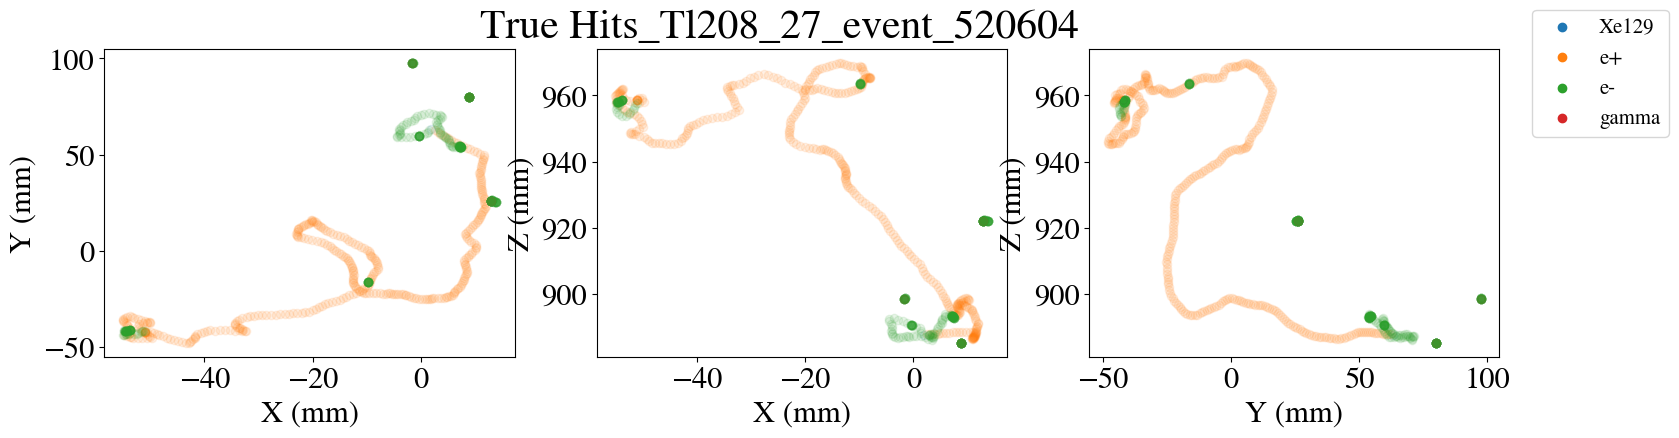

In [122]:
from matplotlib.lines import Line2D


fig, axes = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle('True Hits_' + dir_name, fontsize=30)
added_labels = set()
# Dictionary to store custom handles for the legend
legend_handles = {}
for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000


    axes[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
    axes[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
    axes[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

# Retrieve legend handles and labels
handles, labels = axes[0].get_legend_handles_labels()

# Create a single legend for all subplots
legend = fig.legend(handles, labels, fontsize=15)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.show()

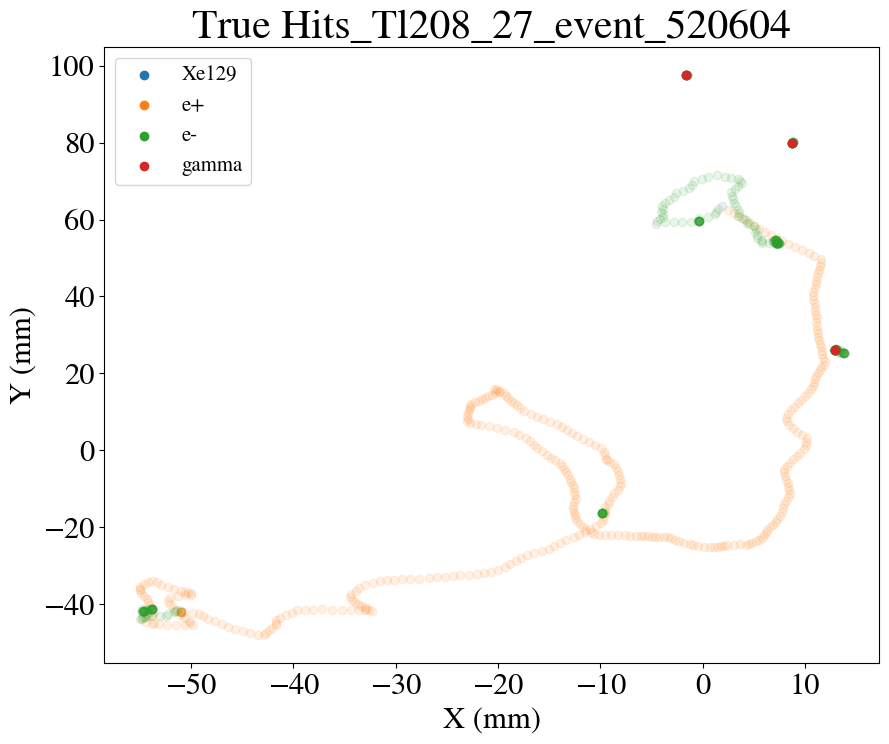

In [123]:
for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000

    if (pid == 'gamma') or (pid == 'Xe131'):
        plt.scatter(xt, yt,  alpha=1, label = str(pid))
    else:
        plt.scatter(xt, yt,  alpha=0.1, label = str(pid))

    
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');

# Retrieve legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a single legend for all subplots
legend = plt.legend(handles, labels, fontsize=15)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.title('True Hits_' + dir_name, fontsize=30)
plt.show()

In [67]:
display(evtmap.head())
print("true:")
display(true_info)
print("soph:")
display(soph_lowTh)
#true_info.head()
display(this_evt_true_info)



,evt_number
nexus_evt,
260000,520000
260001,520002
260002,520004
260003,520006
260004,520008


true:


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,520000,20,0,253.886749,-212.319138,372.275421,2.148397,0.000092,ACTIVE
1,520000,29,0,253.886856,-212.319183,372.275391,2.148428,0.000044,ACTIVE
2,520000,28,0,253.886703,-212.319138,372.275391,2.148409,0.000047,ACTIVE
3,520000,27,0,253.886734,-212.319275,372.275391,2.148433,0.000046,ACTIVE
4,520000,26,0,253.886749,-212.319138,372.275421,2.148405,0.000010,ACTIVE
...,...,...,...,...,...,...,...,...,...
116755,520640,58,21,415.383545,108.210579,127.116730,2.283214,0.000718,ACTIVE
116756,520640,58,22,415.374542,108.207016,127.114326,2.283445,0.001311,ACTIVE
116757,520640,58,23,415.372498,108.212456,127.117752,2.283624,0.001543,ACTIVE
116758,520640,58,24,415.369202,108.211823,127.116798,2.283741,0.001976,ACTIVE


soph:


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520000,5.200012e+11,0.0,237.823620,-217.509278,1.0,225.475,-225.475,0.0,0.0,369.512128,5.101449,236.734026,-1,0.000774,-1,-1
1,520000,5.200012e+11,0.0,237.823620,-217.509278,1.0,225.475,-209.925,0.0,0.0,369.512128,10.144928,470.777938,-1,0.001539,-1,-1
2,520000,5.200012e+11,0.0,237.823620,-217.509278,1.0,241.025,-241.025,0.0,0.0,369.512128,4.811594,223.283232,-1,0.000730,-1,-1
3,520000,5.200012e+11,0.0,237.823620,-217.509278,1.0,241.025,-225.475,0.0,0.0,369.512128,13.913044,645.638310,-1,0.002110,-1,-1
4,520000,5.200012e+11,0.0,237.823620,-217.509278,1.0,241.025,-209.925,0.0,0.0,369.512128,18.144928,842.019953,-1,0.002752,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,520640,5.206420e+11,1.0,347.356042,323.206374,1.0,349.875,318.775,0.0,0.0,670.050544,5.913043,188.888896,-1,0.000843,-1,-1
199,520640,5.206420e+11,1.0,347.356042,323.206374,1.0,349.875,334.325,0.0,0.0,670.050544,5.275362,168.518515,-1,0.000752,-1,-1
200,520640,5.206420e+11,1.0,347.356042,323.206374,1.0,365.425,318.775,0.0,0.0,670.050544,6.492754,207.407411,-1,0.000926,-1,-1
201,520640,5.206420e+11,1.0,347.356042,323.206374,1.0,365.425,334.325,0.0,0.0,670.050544,4.521739,144.444446,-1,0.000645,-1,-1


,event_id,particle_id,hit_id,x,y,z,time,energy,label,particle_name
110328,520604,18,0,-70.110970,-226.820007,423.736542,2.649332,0.000011,ACTIVE,gamma
110329,520604,18,1,307.052490,-72.121788,449.516327,4.011844,0.000082,ACTIVE,gamma
110330,520604,27,0,307.052490,-72.121780,449.516327,4.011846,0.000044,ACTIVE,e-
110331,520604,26,0,307.052643,-72.121674,449.516357,4.011914,0.000021,ACTIVE,e-
110332,520604,25,0,307.052582,-72.121910,449.516449,4.011939,0.000012,ACTIVE,e-
...,...,...,...,...,...,...,...,...,...,...
111041,520604,75,1,-2.379975,189.279327,603.138672,1.594901,0.008440,ACTIVE,e-
111042,520604,75,2,-2.379647,189.262268,603.140137,1.595229,0.001063,ACTIVE,e-
111043,520604,75,3,-2.380787,189.250732,603.132324,1.595516,0.003418,ACTIVE,e-
111044,520604,75,4,-2.384834,189.250320,603.128906,1.595670,0.002593,ACTIVE,e-


In [68]:
pd.set_option('display.max_rows', 500)
# checking the specific thallium decay
soph_file = f'/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/sophronia_27_208Tl.h5'
df_ps = pd.read_hdf(soph_file, 'MC/particles')
df_ps_evt = df_ps[df_ps.event_id == evt/2]
display(df_ps_evt)
display(df_ps_evt[df_ps_evt.particle_name == 'e+'])

display(evtmap[evtmap.evt_number == evt])



,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
24496,260302,1,Tl208,True,0,395.658173,394.948212,533.285645,0.000000,395.658173,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,none,RadioactiveDecay
24497,260302,4,e-,False,1,395.658173,394.948212,533.285645,0.000063,397.717194,...,0.152498,-0.333768,-0.029148,0.000000,0.000000,-0.000000,1.187839e-01,1.613903e+01,RadioactiveDecay,eIoni
24498,260302,5,e-,False,4,398.545349,401.473389,536.400146,0.171246,398.536530,...,-0.009836,0.005262,-0.030013,-0.000000,-0.000000,-0.000000,1.002162e-03,2.897551e-02,eIoni,eIoni
24499,260302,3,anti_nu_e,False,1,395.658173,394.948212,533.285645,0.000063,12500.000000,...,0.803275,0.757549,-0.391937,0.803275,0.757549,-0.391937,1.171642e+00,1.765518e+04,RadioactiveDecay,Transportation
24500,260302,2,Pb208[3708.451],False,1,395.658173,394.948212,533.285645,0.000063,395.658173,...,-0.955772,-0.423780,0.421085,-0.000000,-0.000000,0.000000,3.279449e-06,0.000000e+00,RadioactiveDecay,RadioactiveDecay
24501,260302,7,gamma,False,2,395.658173,394.948212,533.285645,0.000063,484.426208,...,0.486267,-0.029482,0.153393,0.000000,0.000000,-0.000000,5.107393e-01,9.919280e+01,RadioactiveDecay,phot
24502,260302,16,e-,False,7,484.426208,393.013580,561.107300,0.330935,484.426208,...,0.000950,0.002708,-0.007163,-0.000000,0.000000,-0.000000,5.826000e-05,1.450558e-07,phot,msc
24503,260302,15,e-,False,7,484.426208,393.013580,561.107300,0.330935,484.426208,...,0.002002,0.005052,0.005479,0.000000,0.000000,0.000000,5.826000e-05,1.450558e-07,phot,msc
24504,260302,14,e-,False,7,484.426208,393.013580,561.107300,0.330935,484.426208,...,0.010996,0.015819,-0.022789,0.000000,0.000000,-0.000000,8.705800e-04,1.551468e-05,phot,eIoni
24505,260302,13,e-,False,7,484.426208,393.013580,561.107300,0.330935,484.426208,...,0.004015,-0.005476,0.002166,-0.000000,-0.000000,0.000000,4.971000e-05,1.369602e-07,phot,msc


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
24536,260302,42,e+,False,40,-12.302414,194.226715,606.123413,1.536003,-82.779259,...,-1.133315,-0.938659,0.722245,-0.0,0.0,-0.0,1.206045,387.517883,conv,annihil


,evt_number
nexus_evt,
260302,520604


In [69]:

# take event number
print(this_evt_true_info['event_id'].to_numpy()[0])
no = this_evt_true_info['event_id'].to_numpy()[0]
# and file, because we know the last 9 characters are always the same, we can take the number
print(soph_file)
print(soph_file.split('sophronia_')[1].split('_208Tl')[0])
file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
dir_name = "Tl208_" + file_number + "_event_" + str(no)

pre_dir_name = 'beersheba_event_plots/'

if not os.path.isdir(pre_dir_name + dir_name):
    os.mkdir(pre_dir_name +dir_name)


520604
/home/e78368jw/Documents/NEXT_CODE/next_misc/energy_topology_study/testing_data/sophronia_27_208Tl.h5
27


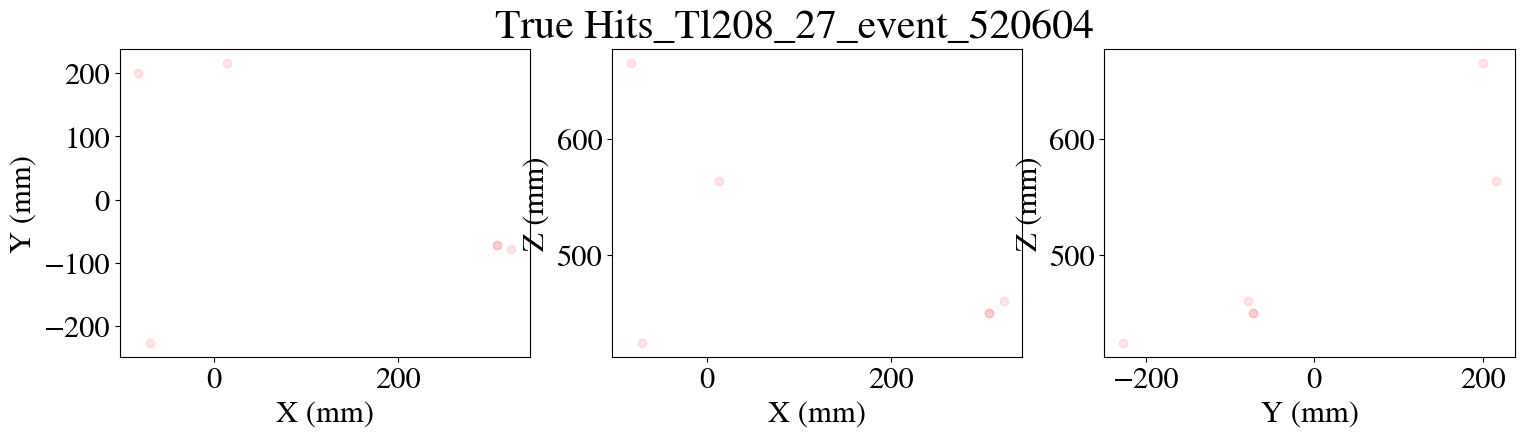

In [70]:
# true data type plots
if (datatype == 'MC'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + dir_name, fontsize=30)
    fig.savefig(pre_dir_name + dir_name + "/MC_hits")

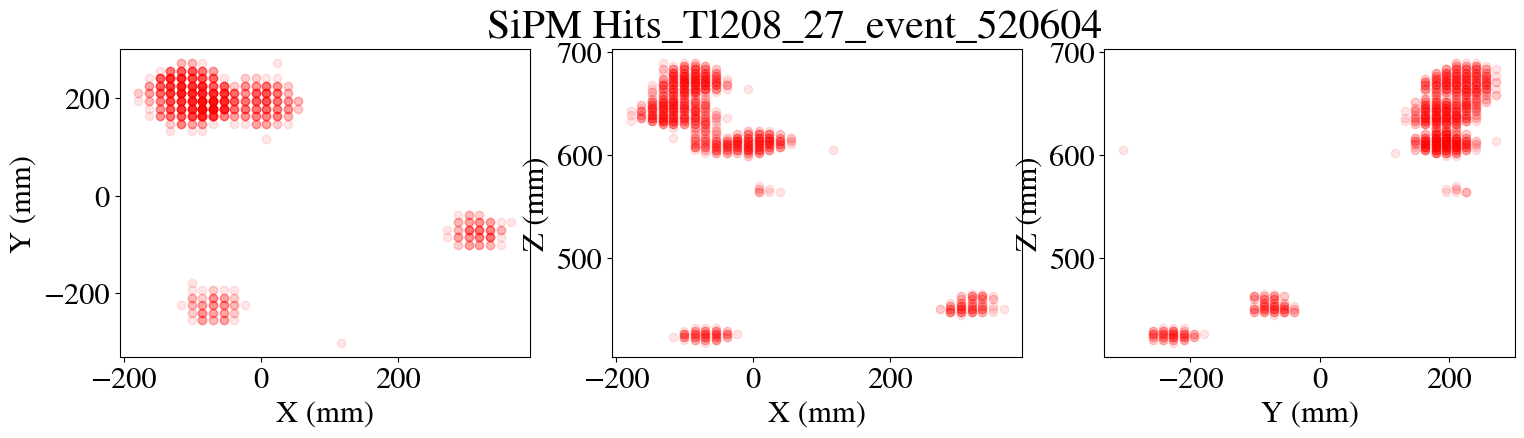

In [71]:
# plotting sipm data normally
# true data type plots

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")

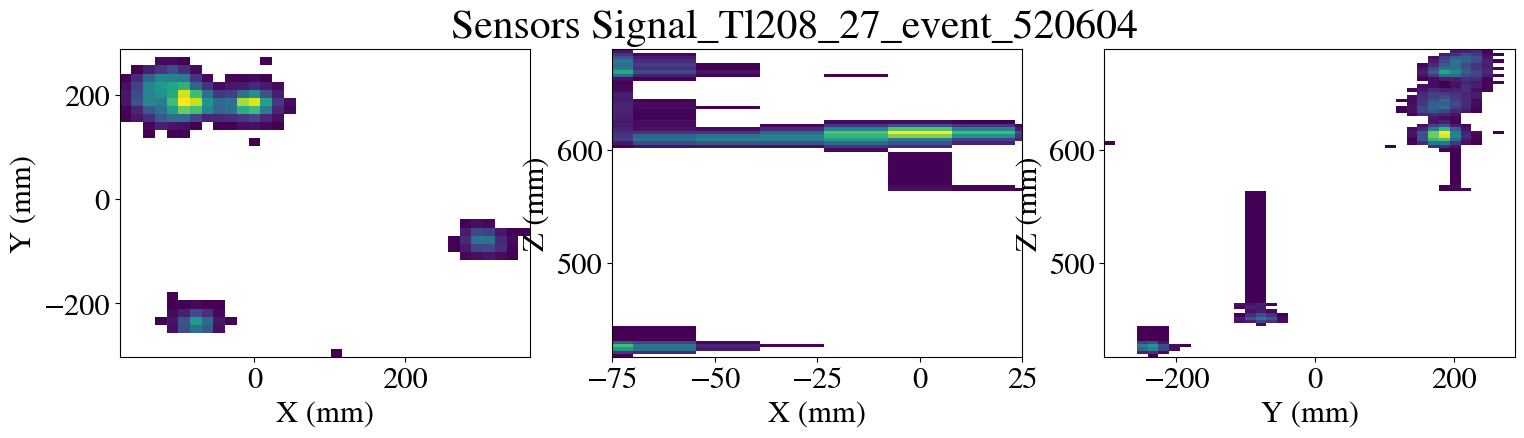

In [72]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);

axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")

#### Cut sensors

 Cut sensors below a given threshold, this cleans the signal and removes hits considered not part of the image. It can be seen that the cut does not harm the image noticeably.

In [73]:
qmin = deconv_params['q_cut']
print(f'Cutting sensors below {qmin}')

Cutting sensors below 4


In [74]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

Time spent in cut_over_Q: 0.01530003547668457 s


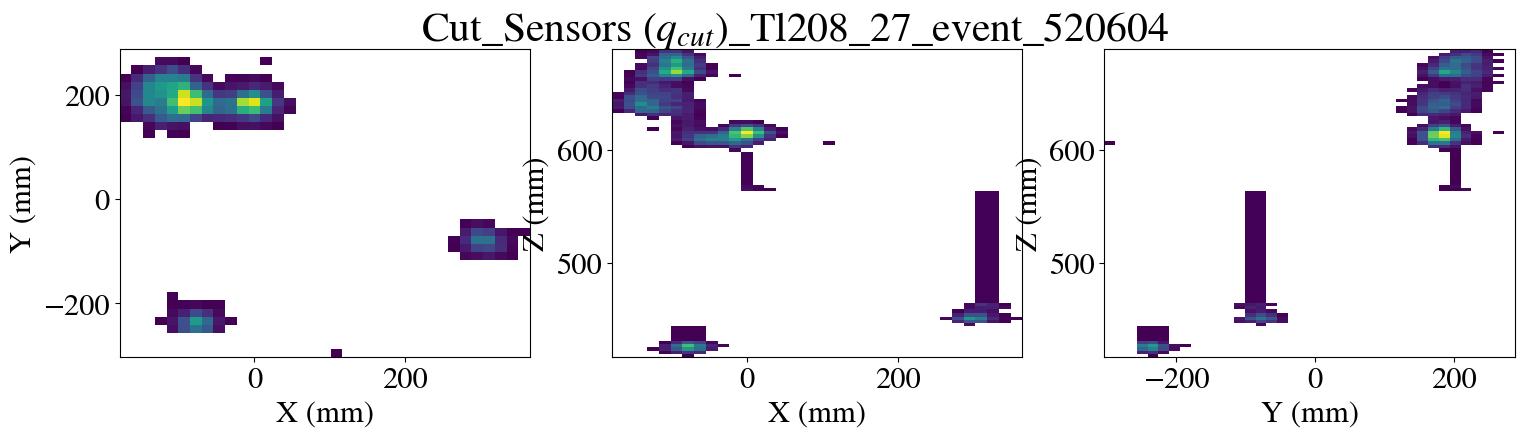

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")

Increased cut to see the impact of the function on higher thresholds:

In [76]:
cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())

Time spent in cut_over_Q: 0.01461338996887207 s


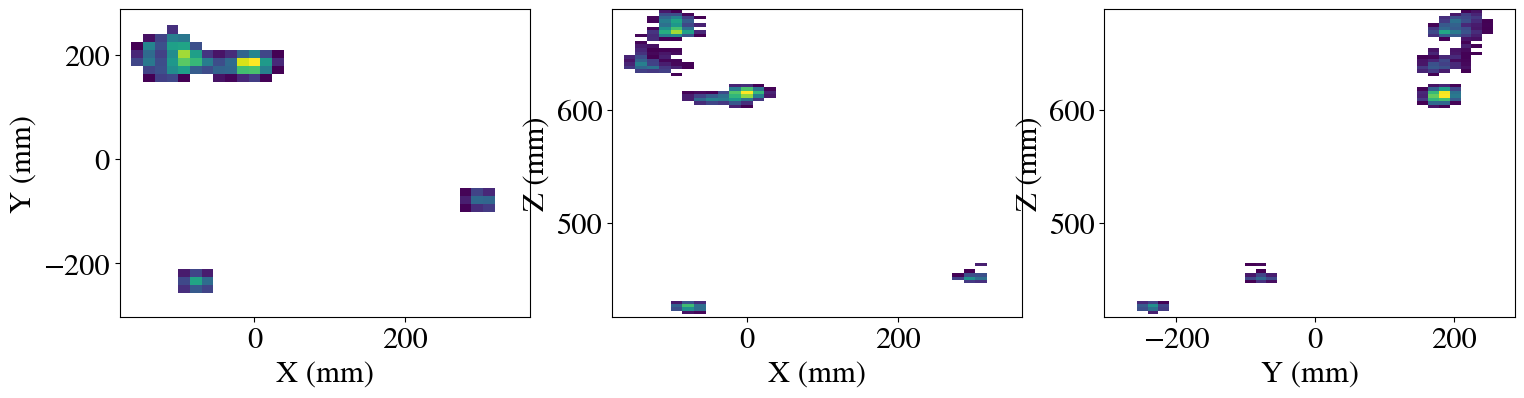

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the remaining hits so the total energy of the event remains the same:

In [78]:
print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')

Energy (corrected) before cuts:    596248.0 (1.9108215502038424)
Energy (corrected) after low cut:  596248.0 (1.910821550203842)
Energy (corrected) after high cut: 590867.0 (1.8936853411440984)


#### Drop isolated sensors

Cut sensors that are isolated in XY. Basically drops a sensor if there are no sensors near-by (distance can be configurable) that have seen light in the event.

In [79]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.018719911575317383 s


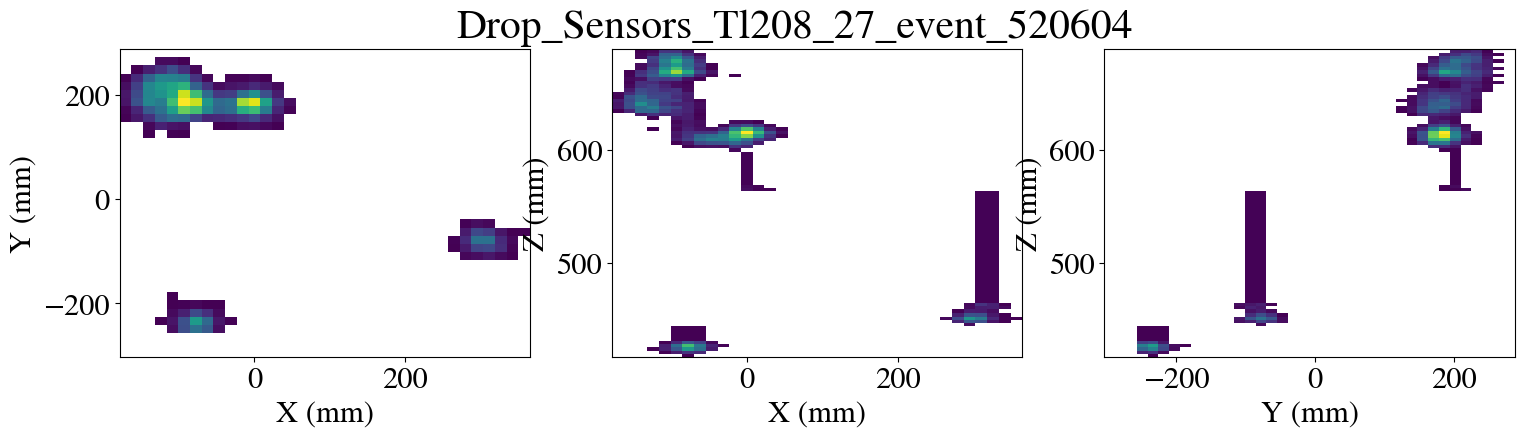

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")


It usually does not make a difference, as it's not usual to have rogue SiPMs. Let's add one and check the performance of the function:

In [81]:
hits_cut.loc[len(hits_cut)] = hits_cut.loc[0].values
hits_cut.loc[len(hits_cut)-1, ['X', 'Y', 'Q']] = [-250, -250, 1000]

In [82]:
hits_cut.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
992,520604.0,5.206055e+11,4.0,-68.171920,199.807461,1.0,-132.175,209.925,0.0,0.0,688.863197,4.231884,278.000515,-1.0,0.000904,-1.0,-1.0
993,520604.0,5.206055e+11,4.0,-68.171920,199.807461,1.0,-101.075,241.025,0.0,0.0,688.863197,5.159420,338.932152,-1.0,0.001102,-1.0,-1.0
994,520604.0,5.206055e+11,4.0,-68.171920,199.807461,1.0,-85.525,209.925,0.0,0.0,688.863197,6.492754,426.521367,-1.0,0.001387,-1.0,-1.0
995,520604.0,5.206055e+11,4.0,-68.171920,199.807461,1.0,-85.525,225.475,0.0,0.0,688.863197,5.971014,392.247307,-1.0,0.001276,-1.0,-1.0
996,520604.0,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-250.000,-250.000,0.0,0.0,416.970028,1000.000000,578.000000,-1.0,0.001821,-1.0,-1.0


### be not afraid of these plots, notebook-wanderer. For these are purposefully crap to demonstrate how to modify the event

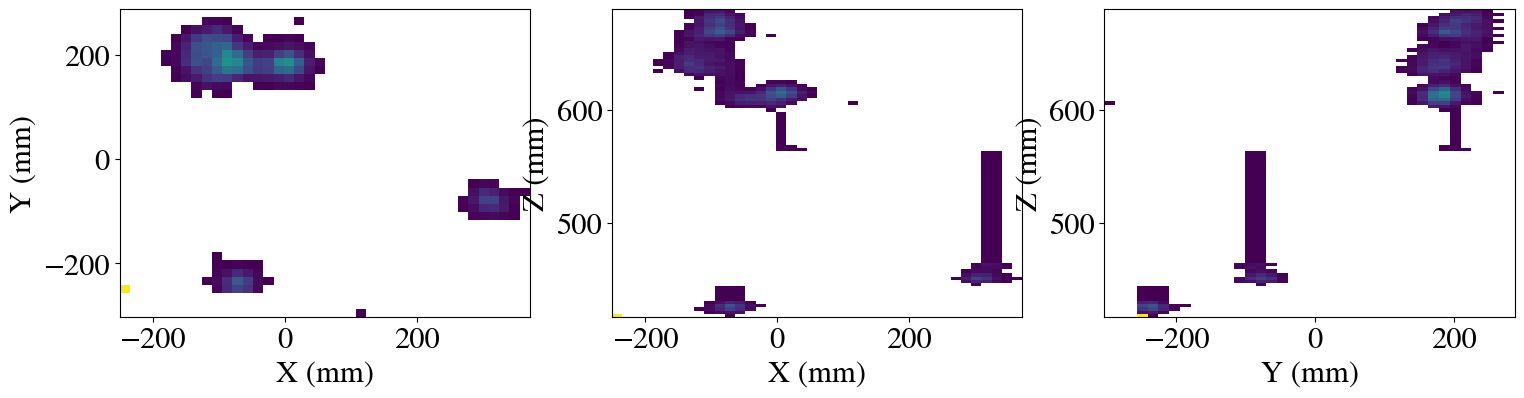

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_cut.X.min(), hits_cut.X.max() + pitch, pitch)
yy = np.arange(hits_cut.Y.min(), hits_cut.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



And now after cut:


In [84]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.047463178634643555 s


In [85]:
hits_drop.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520604.0,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-69.975,-225.475,0.0,0.0,416.970028,4.463768,584.152220,-1.0,0.001840,-1.0,-1.0
1,520604.0,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-256.575,0.0,0.0,419.908748,4.231884,180.976277,-1.0,0.000573,-1.0,-1.0
2,520604.0,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-54.425,-256.575,0.0,0.0,419.908748,5.739130,245.433586,-1.0,0.000776,-1.0,-1.0
3,520604.0,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-101.075,-209.925,0.0,0.0,419.908748,4.231884,180.976277,-1.0,0.000573,-1.0,-1.0
4,520604.0,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-241.025,0.0,0.0,419.908748,11.188406,478.471540,-1.0,0.001514,-1.0,-1.0


When cutting, the energy is distributed through the reminding hits so the total energy of the event remains the same. The increment is due to the additional hit to hits_copy which caused an increase in the input energy. Still the energy before and after the cut remains the same as should be expected.

In [86]:
print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')

Energy (corrected) before cut: 596826.0 (1.912642334310961)
Energy (corrected) after  cut: 596826.0000000002 (1.9126423343109615)


Recover the hits as they should (normal cuts):

In [87]:
hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.031592369079589844 s
Time spent in drop_isolated: 0.028595924377441406 s


#### Deconvolve Signal 

Last function in the city is deconvolve_signal which basically chooses the deconvolution mode (either 2D or 3D, and joint or separate, see code description) and calls deconvolve function (once per S2 peak). Which first interpolates the signal and then deconvolves it. After all the process, deconvolve_signal assigns the energy, measured by the PMTs (corrected or not, chosen by parameter) to each deconvolved hit based on their fraction of energy of the full S2 peak.

Hereunder, deconvolve_signal output will be showed. Individual performance of each step will be looked into later in the notebook.

In [88]:
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Time spent in apply_deconvolution: 4.4790122509002686 s


In [89]:
# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']
print(save_state)

75


In [90]:
display(hits)
display(hits_cut)
display(hits_drop)
display(hits_deco)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-69.975,-225.475,0.0,0.0,416.970028,4.463768,578.000000,-1,0.001821,-1,-1
1,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-256.575,0.0,0.0,419.908748,4.231884,179.070256,-1,0.000567,-1,-1
2,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-54.425,-256.575,0.0,0.0,419.908748,5.739130,242.848710,-1,0.000768,-1,-1
3,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-101.075,-209.925,0.0,0.0,419.908748,4.231884,179.070256,-1,0.000567,-1,-1
4,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-241.025,0.0,0.0,419.908748,11.188406,473.432336,-1,0.001498,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-101.075,256.575,0.0,0.0,685.922475,7.536232,272.318782,-1,0.000889,-1,-1
1002,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-132.175,209.925,0.0,0.0,688.863197,4.231884,277.283810,-1,0.000902,-1,-1
1003,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-101.075,241.025,0.0,0.0,688.863197,5.159420,338.058361,-1,0.001099,-1,-1
1004,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-85.525,209.925,0.0,0.0,688.863197,6.492754,425.421764,-1,0.001383,-1,-1


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-69.975,-225.475,0.0,0.0,416.970028,4.463768,578.000000,-1,0.001821,-1,-1
1,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-256.575,0.0,0.0,419.908748,4.231884,179.070256,-1,0.000567,-1,-1
2,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-54.425,-256.575,0.0,0.0,419.908748,5.739130,242.848710,-1,0.000768,-1,-1
3,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-101.075,-209.925,0.0,0.0,419.908748,4.231884,179.070256,-1,0.000567,-1,-1
4,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-241.025,0.0,0.0,419.908748,11.188406,473.432336,-1,0.001498,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-101.075,256.575,0.0,0.0,685.922475,7.536232,273.022653,-1,0.000891,-1,-1
992,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-132.175,209.925,0.0,0.0,688.863197,4.231884,278.000515,-1,0.000904,-1,-1
993,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-101.075,241.025,0.0,0.0,688.863197,5.159420,338.932152,-1,0.001102,-1,-1
994,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-85.525,209.925,0.0,0.0,688.863197,6.492754,426.521367,-1,0.001387,-1,-1


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-69.975,-225.475,0.0,0.0,416.970028,4.463768,578.000000,-1,0.001821,-1,-1
1,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-256.575,0.0,0.0,419.908748,4.231884,179.070256,-1,0.000567,-1,-1
2,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-54.425,-256.575,0.0,0.0,419.908748,5.739130,242.848710,-1,0.000768,-1,-1
3,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-101.075,-209.925,0.0,0.0,419.908748,4.231884,179.070256,-1,0.000567,-1,-1
4,520604,5.206055e+11,0.0,-68.472732,-229.157518,1.0,-85.525,-241.025,0.0,0.0,419.908748,11.188406,473.432336,-1,0.001498,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-101.075,256.575,0.0,0.0,685.922475,7.536232,273.188361,-1,0.000891,-1,-1
990,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-132.175,209.925,0.0,0.0,688.863197,4.231884,278.169243,-1,0.000905,-1,-1
991,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-101.075,241.025,0.0,0.0,688.863197,5.159420,339.137862,-1,0.001103,-1,-1
992,520604,5.206055e+11,4.0,-68.171920,199.807461,1.0,-85.525,209.925,0.0,0.0,688.863197,6.492754,426.780238,-1,0.001388,-1,-1


,event,npeak,X,Y,Z,E,Xpeak,Ypeak
0,520604,0.0,-72.325,-226.325,416.970028,0.000009,-68.472732,-229.157518
1,520604,0.0,-72.325,-225.325,416.970028,0.000011,-68.472732,-229.157518
2,520604,0.0,-72.325,-224.325,416.970028,0.000010,-68.472732,-229.157518
3,520604,0.0,-72.325,-223.325,416.970028,0.000007,-68.472732,-229.157518
4,520604,0.0,-71.325,-227.325,416.970028,0.000010,-68.472732,-229.157518
...,...,...,...,...,...,...,...,...
13449,520604,4.0,-86.325,223.675,685.922475,0.000154,-68.171920,199.807461
13450,520604,4.0,-86.325,224.675,685.922475,0.000153,-68.171920,199.807461
13451,520604,4.0,-86.325,225.675,685.922475,0.000146,-68.171920,199.807461
13452,520604,4.0,-85.325,222.675,685.922475,0.000145,-68.171920,199.807461


In [91]:

i = 0
for iterN in np.arange(5, deconv_params_['n_iterations'], 5):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
    
        # using the same X-Y-Z from hits_drop
    if (i == 0):
        xx = np.arange(hits_drop.X.min(), hits_drop.X.max())
        yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max())
        zz = hits_drop.Z.unique()
        i += 1

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E*1000, cmin=0.0001);
    if (datatype == 'MC'):
        axes[0].scatter(xt, yt,  alpha=0.01, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E*1000, cmin=0.0001);
    if (datatype == 'MC'):
        axes[1].scatter(xt, zt,  alpha=0.01, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E*1000, cmin=0.0001);
    if (datatype == 'MC'):
        axes[2].scatter(yt, zt,  alpha=0.01, color='red')
    
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');


    fig.suptitle('deconvolved_with_MC_' + str(520470) + "_iteration " + str(iterN), fontsize=30)
    fig.savefig('/home/e78368jw/Documents/NEXT_CODE/next_misc/miscellaneous/plots_dodgy_events/dodgy_event_deconv/520470_dodgy_iter_' + str(iterN) + '.png')
    plt.close(fig)


5 iterations
Time spent in apply_deconvolution: 0.844829797744751 s
10 iterations
Time spent in apply_deconvolution: 1.0430982112884521 s
15 iterations
Time spent in apply_deconvolution: 1.1629502773284912 s
20 iterations
Time spent in apply_deconvolution: 1.457428216934204 s
25 iterations
Time spent in apply_deconvolution: 1.8504524230957031 s
30 iterations
Time spent in apply_deconvolution: 2.162071704864502 s
35 iterations
Time spent in apply_deconvolution: 2.283834934234619 s
40 iterations
Time spent in apply_deconvolution: 2.6057374477386475 s
45 iterations
Time spent in apply_deconvolution: 2.785130500793457 s
50 iterations
Time spent in apply_deconvolution: 3.2277677059173584 s
55 iterations
Time spent in apply_deconvolution: 3.472080707550049 s
60 iterations
Time spent in apply_deconvolution: 3.6789052486419678 s
65 iterations
Time spent in apply_deconvolution: 4.019158601760864 s
70 iterations
Time spent in apply_deconvolution: 4.363571882247925 s


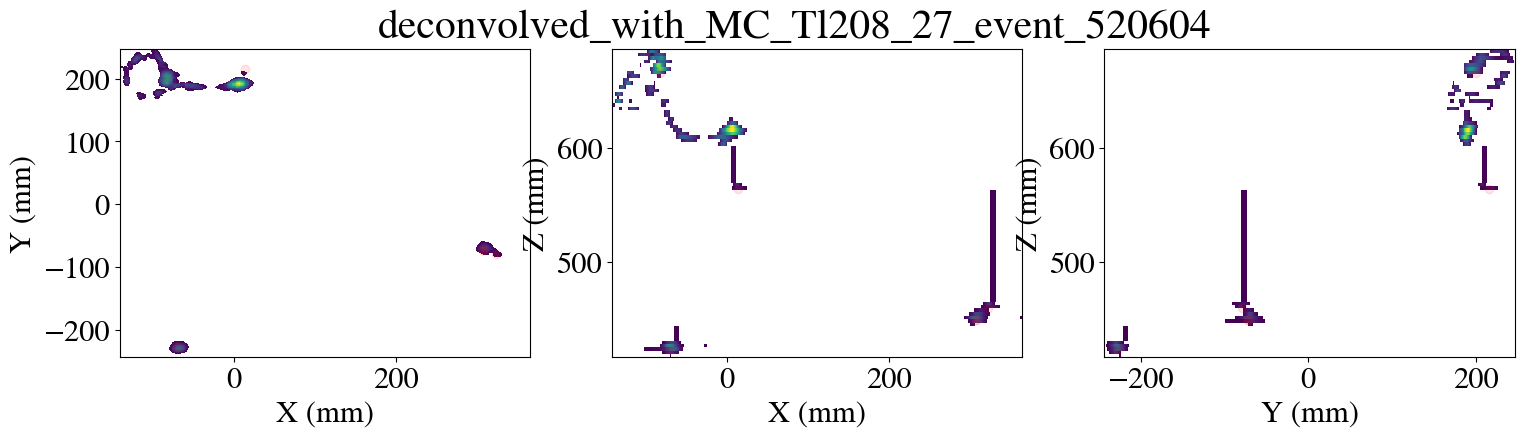

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_deco.X.min(), hits_deco.X.max())
yy = np.arange(hits_deco.Y.min(), hits_deco.Y.max())
zz = hits_deco.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")

In [93]:
x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E

In [94]:
display(hits_deco)
#print(hits_deco.groupby('Z').sum())

,event,npeak,X,Y,Z,E,Xpeak,Ypeak
0,520604,0.0,-72.325,-226.325,416.970028,0.000009,-68.472732,-229.157518
1,520604,0.0,-72.325,-225.325,416.970028,0.000011,-68.472732,-229.157518
2,520604,0.0,-72.325,-224.325,416.970028,0.000010,-68.472732,-229.157518
3,520604,0.0,-72.325,-223.325,416.970028,0.000007,-68.472732,-229.157518
4,520604,0.0,-71.325,-227.325,416.970028,0.000010,-68.472732,-229.157518
...,...,...,...,...,...,...,...,...
13449,520604,4.0,-86.325,223.675,685.922475,0.000154,-68.171920,199.807461
13450,520604,4.0,-86.325,224.675,685.922475,0.000153,-68.171920,199.807461
13451,520604,4.0,-86.325,225.675,685.922475,0.000146,-68.171920,199.807461
13452,520604,4.0,-85.325,222.675,685.922475,0.000145,-68.171920,199.807461


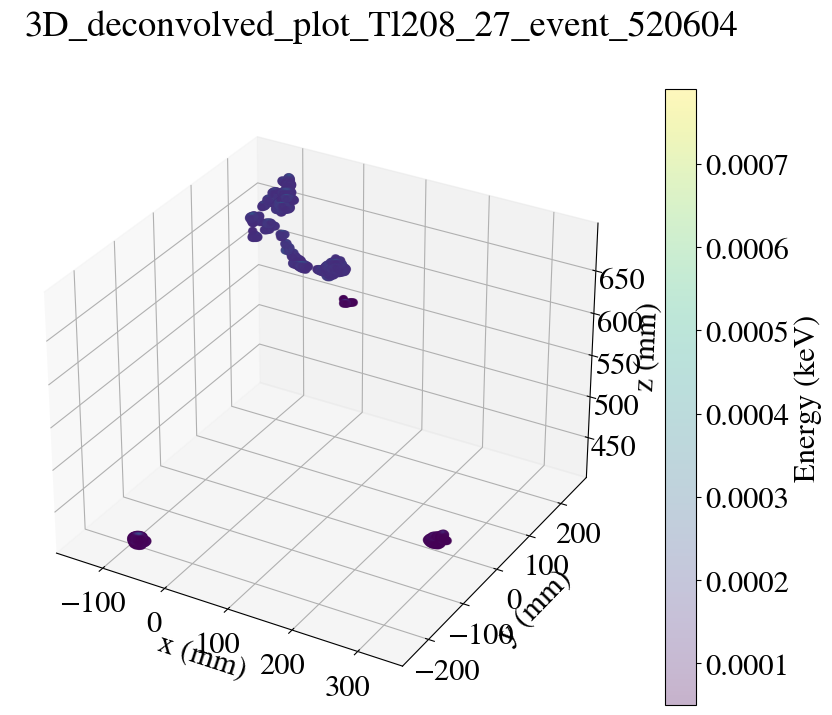

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
em = e > 0.00005
p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

fig.suptitle('3D_deconvolved_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

plt.show()

/tmp/ipykernel_6195/4182008797.py:56: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


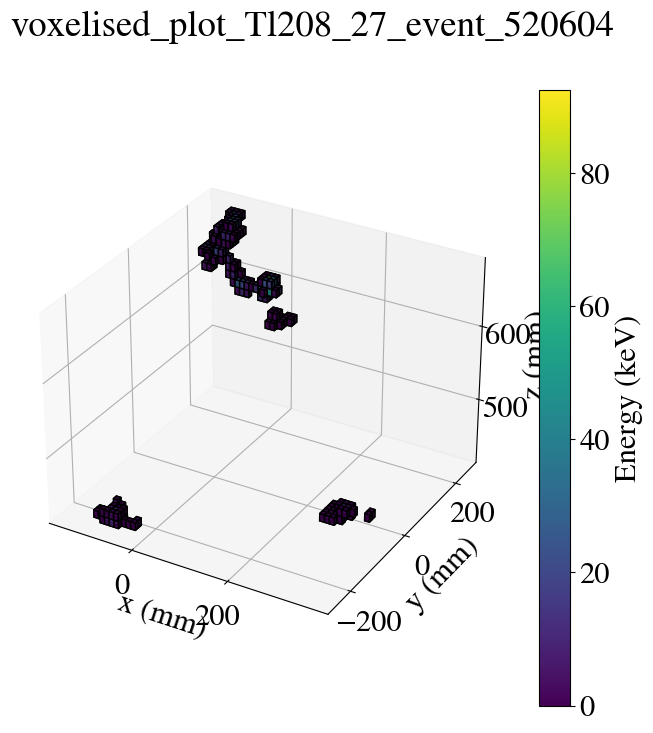

In [124]:
base_vsize = 10 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

plt.show()

In [50]:
hits_deco.head()

,event,npeak,X,Y,Z,E
0,3580184,0.0,162.675,379.675,153.902756,0.000051
1,3580184,0.0,162.675,380.675,153.902756,0.000062
2,3580184,0.0,162.675,381.675,153.902756,0.000053
3,3580184,0.0,163.675,379.675,153.902756,0.000058
4,3580184,0.0,163.675,380.675,153.902756,0.000059


In [51]:
display(hits_drop.head())
(print(hits_drop.Ec.sum()))

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,365.425,0.0,0.0,153.902756,12.637681,1090.965504,-1,0.003672,-1,-1
1,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,380.975,0.0,0.0,153.902756,8.115942,700.620055,-1,0.002397,-1,-1
2,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,163.275,365.425,0.0,0.0,154.910446,15.130435,658.369885,-1,0.002216,-1,-1
3,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,349.875,0.0,0.0,154.910446,9.739130,423.778293,-1,0.001385,-1,-1
4,3580184,3.580185e+12,0.0,159.362449,329.66967,1.0,178.825,365.425,0.0,0.0,154.910446,11.884058,517.110440,-1,0.001741,-1,-1


1.5969519152853373


In [52]:
display(true_info)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,3580000,33,0,-46.194996,467.190399,431.942200,1.535779,0.000067,ACTIVE
1,3580000,33,1,-55.469902,471.587219,515.781616,1.817526,0.000070,ACTIVE
2,3580000,33,2,-260.563843,156.963150,379.097809,3.150674,0.000209,ACTIVE
3,3580000,58,0,-260.563843,156.963150,379.097809,3.150674,0.000021,ACTIVE
4,3580000,57,0,-260.563843,156.963043,379.097778,3.150701,0.000044,ACTIVE
...,...,...,...,...,...,...,...,...,...
125194,3580710,11,66,465.195312,47.502777,655.698425,1.556505,0.001955,ACTIVE
125195,3580710,11,67,465.203644,47.507076,655.708740,1.556792,0.001550,ACTIVE
125196,3580710,11,68,465.208984,47.499176,655.710632,1.557019,0.001224,ACTIVE
125197,3580710,11,69,465.209167,47.492569,655.711853,1.557197,0.002001,ACTIVE


In [53]:
break;

SyntaxError: 'break' outside loop (1693679151.py, line 1)

### Create a loop that does it all

In [ ]:
#

In [17]:
for i in range(len(hdst.event.unique())):
	evt = hdst.event.unique()[i+90]
	hits = hdst[hdst.event == evt]
	
	x_range = (hits.X.max()-hits.X.min())/2.
	y_range = (hits.Y.max()-hits.Y.min())/2.
	z_range = (hits.Z.max()-hits.Z.min())/2.
	mid_x   = (hits.X.max()+hits.X.min())/2.
	mid_y   = (hits.Y.max()+hits.Y.min())/2.
	mid_z   = (hits.Z.max()+hits.Z.min())/2.

	print("X maximum and minimum")
	print(hits.X.max(), hits.X.min())
	print("")

	print("Y maximum and minimum")
	print(hits.Y.max(), hits.Y.min())
	print("")

	print("Z maximum and minimum")
	print(hits.Z.max(), hits.Z.min())

	xbins = int(hits.X.max()-hits.X.min())
	ybins = int(hits.Y.max()-hits.Y.min())
	zbins = int((hits.Z.max()-hits.Z.min())/2.)
	
	
	if (datatype == 'MC'):
	    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
	    true_info = mcio.load_mchits_df(soph_file).reset_index()
	    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
	    
	    
	    this_evt_true_info = true_info[true_info.event_id == evt]

	    xt = this_evt_true_info.x
	    yt = this_evt_true_info.y
	    zt = this_evt_true_info.z
	    et = this_evt_true_info.energy*1000
	
	no = this_evt_true_info['event_id'].to_numpy()[0]
	file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
	dir_name = "Tl208_" + file_number + "_event_" + str(no)

	pre_dir_name = 'beersheba_event_plots/'

	if not os.path.isdir(pre_dir_name + dir_name):
	    os.mkdir(pre_dir_name +dir_name)
	
	
	# true data type plots
	if (datatype == 'MC'):
	    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	    axes[0].set_xlabel('X (mm)');
	    axes[0].set_ylabel('Y (mm)');

	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	    axes[1].set_xlabel('X (mm)');
	    axes[1].set_ylabel('Z (mm)');

	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	    axes[2].set_xlabel('Y (mm)');
	    axes[2].set_ylabel('Z (mm)');
	    
	    fig.suptitle('True Hits_' + dir_name, fontsize=30)
	    fig.savefig(pre_dir_name + dir_name + "/MC_hits")
	    plt.close()
	   
	# plotting sipm data normally
	# true data type plots

	fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")
	plt.close()
	
	
	
	# then applying transformations to convert to 'SiPM outputs'
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))


	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")
	plt.close()
	
	
	qmin = deconv_params['q_cut']
	print(f'Cutting sensors below {qmin}')
	
	hits_cut = coref.timefunc(cut_sensors)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")
	plt.close()
	
	
	cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
	hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()
	
	
	print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
	print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')
	
	
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")
	plt.close()
	
	print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')
	
	hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	
	
	# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
	if 'save_state' in locals():
	    deconv_params_['n_iterations'] = save_state
	else:
	    # first time round, so set it
	    save_state = deconv_params_['n_iterations']
	print(save_state)
	
	
	
		
	for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
	    deconv_params_['n_iterations'] = iterN
	    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	    print(f'{iterN} iterations')
	    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	    
	    
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max())
	yy = np.arange(hits.Y.min(), hits.Y.max())
	zz = hits.Z.unique()

	axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()


	fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")
	
	x = hits_deco.X
	y = hits_deco.Y
	z = hits_deco.Z
	e = hits_deco.E*1000
	
	
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')

	p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
	cb = fig.colorbar(p, ax=ax)
	cb.set_label('Energy (keV)')

	ax.set_xlabel('x (mm)')
	ax.set_ylabel('y (mm)')
	ax.set_zlabel('z (mm)')

	fig.suptitle('3D_deconvolved_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

	plt.close()
	
	# voxel size here
	base_vsize = 15 #mm
	the_hits = []

	xs = hits_deco.X
	ys = hits_deco.Y
	zs = hits_deco.Z
	es = hits_deco.E

	for x, y, z, e in zip(xs, ys, zs, es):
	    if np.isnan(e): continue
	    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
	    the_hits.append(h)

	voxels = voxelize_hits(the_hits,
		               np.array([base_vsize, base_vsize, base_vsize]), False)

	vsizex = voxels[0].size[0]
	vsizey = voxels[0].size[1]
	vsizez = voxels[0].size[2]

	min_corner_x = min(v.X for v in voxels) - vsizex/2.
	min_corner_y = min(v.Y for v in voxels) - vsizey/2.
	min_corner_z = min(v.Z for v in voxels) - vsizez/2.

	x = [np.round(v.X/vsizex) for v in voxels]
	y = [np.round(v.Y/vsizey) for v in voxels]
	z = [np.round(v.Z/vsizez) for v in voxels]
	e = [v.E for v in voxels]

	x_min = int(min(x))
	y_min = int(min(y))
	z_min = int(min(z))

	x_max = int(max(x))
	y_max = int(max(y))
	z_max = int(max(z))

	#print(f'X min = {x_min}, X max = {x_max}')
	#print(f'Y min = {y_min}, Y max = {y_max}')
	#print(f'Z min = {z_min}, Z max = {z_max}')

	VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
	#print(VOXELS.shape)

	# sort through the event set the "turn on" the hit voxels
	cmap = cm.viridis
	norm = Normalize(vmin=0, vmax=max(e))

	colors = np.empty(VOXELS.shape, dtype=object)
	for q in range(0,len(z)):
	    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
	    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

	# and plot everything
	fig = plt.figure(figsize=(8,8))
	ax = fig.gca(projection='3d')
	#a,b,c is spacing in mm needs an extra dim
	a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
	a = a*vsizex + min_corner_x
	b = b*vsizey + min_corner_y
	c = c*vsizez + min_corner_z

	# a, b, c are the corners of the voxels
	ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

	ax.set_xlabel('x (mm)')#,fontsize=16)
	ax.set_ylabel('y (mm)')#,fontsize=16)
	ax.set_zlabel('z (mm)')#,fontsize=16)

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cb = fig.colorbar(sm)
	cb.set_label('Energy (keV)')

	fig.suptitle('voxelised_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

	plt.close()

X maximum and minimum
241.025 69.975

Y maximum and minimum
396.525 256.575

Z maximum and minimum
221.98968505859375 153.9027557373047
Cutting sensors below 5
Time spent in cut_over_Q: 0.015340805053710938 s
Time spent in cut_over_Q: 0.018148422241210938 s
Energy (corrected) before cuts:    490590.00385841954 (1.5969519152853375)
Energy (corrected) after low cut:  490590.00385841954 (1.5969519152853375)
Energy (corrected) after high cut: 490590.0038584196 (1.5969519152853375)
Time spent in drop_isolated: 0.03551197052001953 s
Energy (corrected) before cut: 490590.00385841954 (1.5969519152853375)
Energy (corrected) after  cut: 490590.00385841954 (1.5969519152853375)
Time spent in cut_over_Q: 0.011686325073242188 s
Time spent in drop_isolated: 0.016998767852783203 s
Time spent in apply_deconvolution: 8.77209734916687 s
100
15 iterations
Time spent in apply_deconvolution: 1.9434130191802979 s
30 iterations
Time spent in apply_deconvolution: 2.996838092803955 s
45 iterations
Time spent in

/tmp/ipykernel_31917/2101591017.py:341: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


X maximum and minimum
396.525 54.425

Y maximum and minimum
458.725 272.125

Z maximum and minimum
578.9918823242188 516.0628662109375
Cutting sensors below 5
Time spent in cut_over_Q: 0.03516030311584473 s
Time spent in cut_over_Q: 0.01817798614501953 s
Energy (corrected) before cuts:    105130.99870483472 (0.4198091671128144)
Energy (corrected) after low cut:  105130.99870483472 (0.4198091671128144)
Energy (corrected) after high cut: 105130.99870483474 (0.41980916711281435)
Time spent in drop_isolated: 0.012527942657470703 s
Energy (corrected) before cut: 105130.99870483472 (0.4198091671128144)
Energy (corrected) after  cut: 105130.99870483472 (0.4198091671128144)
Time spent in cut_over_Q: 0.01805901527404785 s
Time spent in drop_isolated: 0.010131120681762695 s
Time spent in apply_deconvolution: 2.302119493484497 s
100
15 iterations
Time spent in apply_deconvolution: 0.6189408302307129 s
30 iterations
Time spent in apply_deconvolution: 0.8914480209350586 s
45 iterations
Time spent i

KeyboardInterrupt: 